# Exploring sea ice heights with ICESat-2 (ATL07)

Notebook written for the SENSE UK Training Course, March 2021 

* Notebook authors: Romina Piunno, Rachel Tilling
* Based heavily on ICESat-2 Hackweek notebooks by Alek Petty (2019) and Ellen Buckley (2020). Strongly reccomend participating in a future ICEsat-2 hackweek if you get the opportunity, to really explore Python and beyond for ICESat-2 dta analysis. 
* ICESat-2 data are hosted by the National Snow and Ice Data Centre (NSIDC). The ATL07 product can be found at https://nsidc.org/data/atl07. The page also includes tabs for:
    - Product User Guide
    - Correct citation of the product 
    - Technical References (ATL07/ATL10 Algorithm Theoretical Basis Document (ATBD), Data dictionary, Known issues document)

## Notebook objectives
1. Use the icepyx library for ICESat-2 data download
2. Familiarise yourself with the key parameters included in ATL07 data files
3. Read in and plot ATL07 data
4. Understand how parameters change with different surface types
5. Understand how clouds affect surface returns

In [3]:
print('this will be my ATL07 workbook')

this will be my ATL07 workbook


In [2]:
! pip install icepyx

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py
from scipy.interpolate import interp1d
from astropy.time import Time
import readers as rd # for some reason 'reader' works, but 'readers' does not
import os

## 1. Use the icepyx library for ICESat-2 data download

### Download Data

In [ ]:
# Romina - this is where we'll do some cool icepyx stuff. There's a couple of data files they'll need for the tutorial.

### Import Data

In [10]:
# RP - not sure what this is doing

data_loc='/Users/rtilling/Documents/workspace_NASA/TeachingTutoring/SENSE_School_2021/Tutorial/icepyx-data_access_tutorials/' # update to where you downloaded the data
for file in os.listdir(data_loc):
    if file.startswith('ATL07-01_20190324002217_13070201') and file.endswith('.h5'):
        fname = file
print(fname)

ATL07-01_20190324002217_13070201_003_02.h5


In [3]:
# let's just use a sample file 
data_loc = '/Users/rominapiunno/Downloads/wetransfer-38e4b1/'
fname = 'ATL07-01_20190324002217_13070201_003_02.h5'

In [4]:
f = h5py.File(data_loc+fname, 'r')

## 2. Familiarise yourself with the key paremeters included in ATL07 data files

Some key ATL07 parameters and their HDF5 groups are listed below
In Group: gtx/sea_ice_segments/
* latitude 
* longitude
* delta_time
* seg_dist_x: Along-track distance from the equator crossing to the segment centre

In Group: gtx/sea_ice_segments/heights/
* height_segment_height 
* height_segment_confidence 
* height_segment_type 
* height_segment_ssh_flag: Sea Surface Flag (0 = sea ice; 1 = sea surface)
* height_segment_w_gaussian: Width of best fit gaussian

In Group: gtx/sea_ice_segments/stats/
* photon_rate 
* cloud_flag_asr: Cloud probability (0-2 = clear; 3-5 = cloudy; 6 = unknown)

In Group: gtx/sea_ice_segments/geophysical/
* height_segment_lpe: Long period equilibrium tide
* height_segment_mss: Mean sea surface
* height_segment_ocean: Ocean tides
* height_segment_ib: Inverted barometer effect calculated from surface pressure

In [18]:
# Romina - this section isn't really that exciting or insightful for anyone who hasn't used IS2 data before. The parameter names will probably be very confusing,so I've added descriptions as to what they are, but how can we jazz it up?

## 3. Read in and plot ATL07 data

Run the getATL07 function to read the data into a pandas dataframe:

In [5]:
beam='gt1l'
df07= rd.getATL07(f,beam)
df07.head()

,lats,lons,heights,dt,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss,ocean,lpe,ib
0,76.481379,99.57747,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042107
1,76.481379,99.57747,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042107
2,76.481379,99.57747,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042107
3,76.481379,99.57747,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042107
4,76.481379,99.57747,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042107


### Surface type classification

First we want to look at the surface type classifications in ATL07 and demonstrate how the classification algorithm works.

Surface type parameter: Value that indicates segment surface type as sea ice or different types of sea surface. 

 0: cloud_covered 
 
 1: sea ice
 
 2-5: lead

### Cut to smaller region of interest 

In [6]:
lonmin,lonmax,latmin,latmax= [-60,0,85.52,85.57]
region=(df07.lats>latmin)&(df07.lats<latmax)&(df07.lons>lonmin)&(df07.lons<lonmax)
df07_cut=df07[region]

### Map the region
Let's show the area that we are working with first:

In [ ]:
var = 'stype' 

#Set colorbar ranges based on the chosen parameter
vmin=0
vmax=10
ticks=np.arange(vmin,vmax,1)

plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-50)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-80,-40,80,86], ccrs.PlateCarree())
plt.scatter(df07_cut['lons'][::100], df07_cut['lats'][::100],c=df07_cut[var][::100], cmap=plt.cm.get_cmap('RdYlGn').reversed(), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both');

# Romina - this plot looks pretty boring. Maybe something we can get them to do is plot the whole orbit? Then work out how to crop it to the specified ROI.

Geometry must be a Point or LineString
Geometry must be a Point or LineString


# 4. Understand how parameters change with different surface types

### Create subplots showing relationship between parameters
* Plot 1: Photon rate
* Plot 2: Gaussian width
* Plot 3: Location of leads
* Plot 4: Sea ice segment heights 

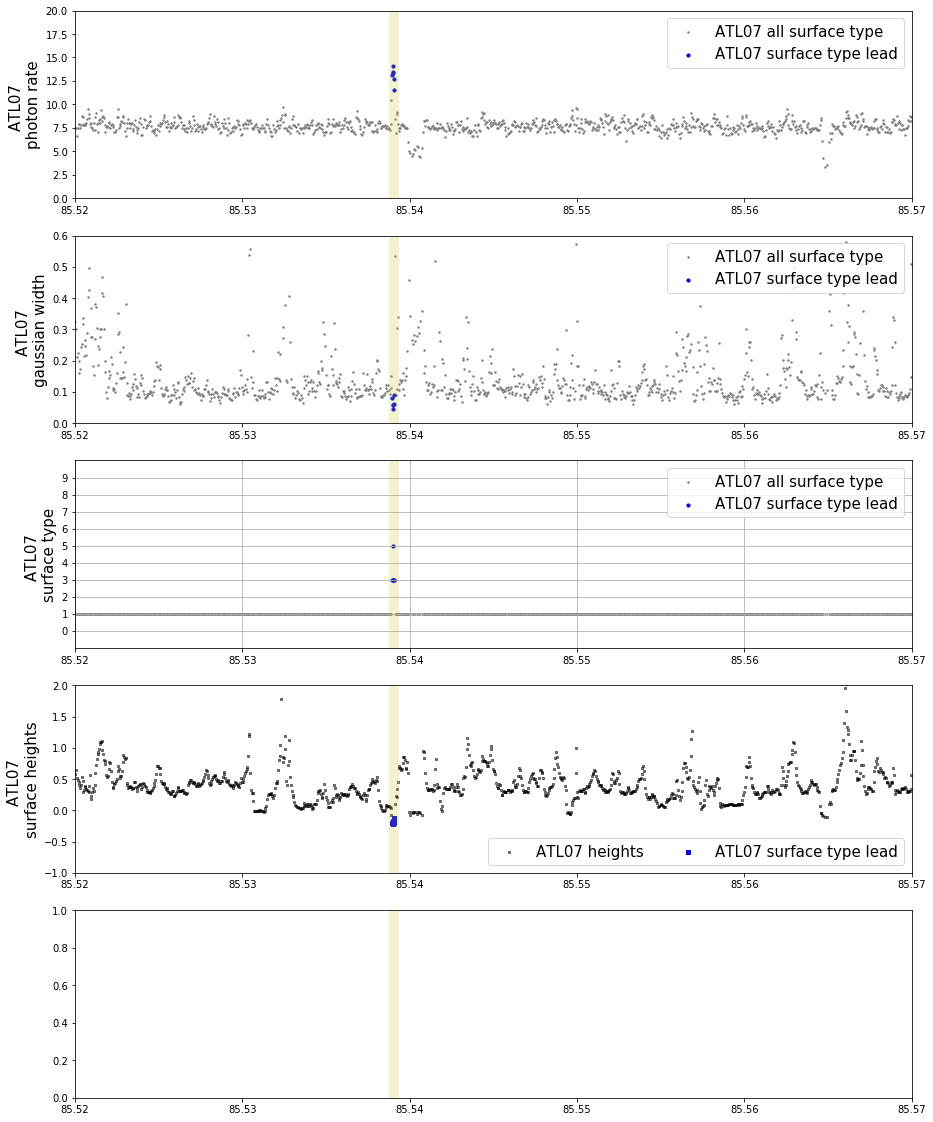

In [21]:
fig,ax=plt.subplots(5,1,figsize=(15,20))

#Plot 1: Photon rate
ax[0].scatter(df07_cut.lats,df07_cut.photon_rate,s=2,c='gray', label='ATL07 all surface type')
ax[0].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].photon_rate,s=10,c='b', label= 'ATL07 surface type lead')
ax[0].legend(fontsize=15)
ax[0].set_ylim(0,20)
ax[0].set_ylabel('ATL07 \nphoton rate',fontsize=15)

#Plot 2: Gaussian width
ax[1].scatter(df07_cut.lats,df07_cut.gauss,s=2,c='gray', label='ATL07 all surface type')
ax[1].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].gauss,s=10,c='blue',label= 'ATL07 surface type lead')
ax[1].legend(loc=1,fontsize=15)
ax[1].set_ylabel('ATL07 \ngaussian width',fontsize=15)
ax[1].set_ylim(0,.6)

#Plot 3: Location of leads
ax[2].grid()
ax[2].scatter(df07_cut.lats,df07_cut.stype,s=2,c='gray',label='ATL07 all surface type')
ax[2].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].stype,s=10,c='blue',label= 'ATL07 surface type lead')
ax[2].legend(fontsize=15)
ax[2].set_ylim(-1,10)
ax[2].set_ylabel('ATL07 \nsurface type',fontsize=15)
ax[2].set_yticks(np.arange(0,10,1))

#Plot 4: Sea ice segment heights 
ax[3].scatter(df07_cut.lats,df07_cut.heights,marker='s',s=5,c='k',alpha=.5, label= 'ATL07 heights')
ax[3].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].heights,marker='s',s=10,c='b', label= 'ATL07 surface type lead')
ax[3].legend(ncol=2, loc=4,fontsize=15)
ax[3].set_ylim(-1,2)
ax[3].set_ylabel('ATL07 \nsurface heights',fontsize=15)

for a in np.arange(0,5):
    ax[a].set_xlim(latmin,latmax)
    ax[a].axvline(df07_cut[df07_cut.ssh_flag==1].lats.values[0],c='y',alpha=.2, linewidth=10)

# Romina - How do I get rid of that bottom plot? Oops!
# We should add some questions or something in here about what they notice


## 5. Understand how clouds affect surface returns

Here we'll use the cloud flag. This is a useful parameter if you want to filter the data. We investigate a section of data that transitions from clear to cloudy and see how that impacts the parameters in ATL07.

In [22]:
data_loc='/Users/rtilling/Documents/workspace_NASA/TeachingTutoring/SENSE_School_2021/Tutorial/icepyx-data_access_tutorials/' # update to where you downloaded the data
for file in os.listdir(data_loc):
    if file.startswith('ATL07-01_20190430080720_04900301') and file.endswith('.h5'):
        fname = file

In [23]:
beam='gt1l'
df07=rd.getATL07(f,beam)
df07.head()

,lats,lons,heights,dt,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss,ocean,lpe,ib
0,76.481379,99.57747,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042107
1,76.481379,99.57747,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042107
2,76.481379,99.57747,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042107
3,76.481379,99.57747,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042107
4,76.481379,99.57747,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042107


### Map cloud data

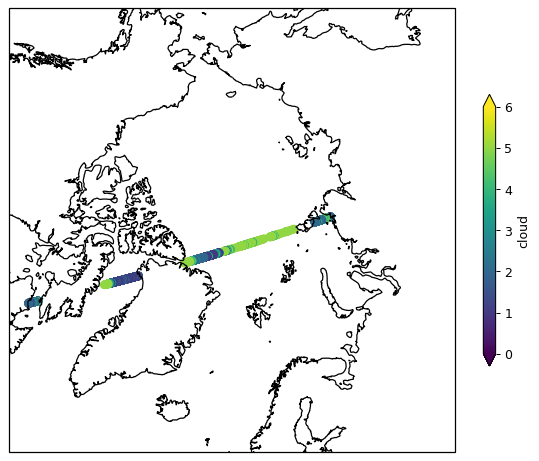

In [24]:
var = 'cloud' #Choose which parameter we want to plot

#Set colorbar ranges based on the chosen parameter
vmin=0
vmax=6
ticks=np.arange(vmin,vmax+1,1)

plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
plt.scatter(df07['lons'][::100], df07['lats'][::100],c=df07[var][::100], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())#plt.cm.get_cmap('RdYlGn').reversed()
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both');

The cloud parameter (cloud_flag_asr) ranges from 0 to 6 and comes from the ATL09 atmosphere product:
* 0: high confidence clear
* 1: medium confidence clear
* 2: low confidence clear
* 3: low confidence cloudy
* 4: medium confidence cloudy
* 5: high confidence cloudy
* 6: unknown

### How do clouds affect parameters?
To explore this we will look at the photon rate parameter (photon_rate). This is the average number of photons returned per shot over a segment. 

In [25]:
#Cut to region that has clear and cloudy data
lonmin,lonmax,latmin,latmax= [170,180,85.6,86]
region=(df07.lats>latmin)&(df07.lats<latmax)&(df07.lons>lonmin)&(df07.lons<lonmax)
df07_cut=df07[region]

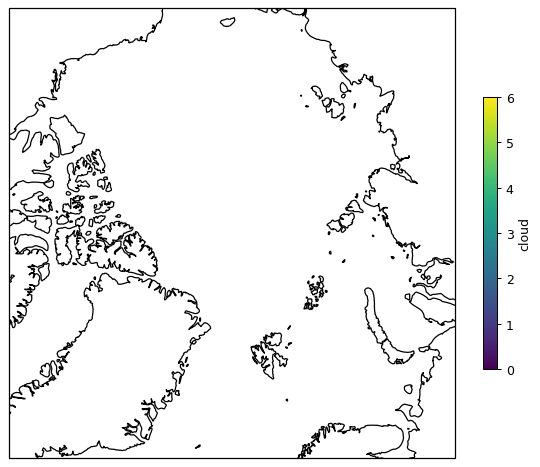

In [26]:
var= 'cloud' #Choose which parameter we want to plot

#Set colorbar ranges based on the chosen parameter
vmin=0
vmax=6
ticks=np.arange(vmin,vmax+1,1)


plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, 70, 90], ccrs.PlateCarree())
plt.scatter(df07_cut['lons'][::10], df07_cut['lats'][::10],c=df07_cut[var][::10], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='neither');

### Compare cloud flag and photon rate parameter

ValueError: min() arg is an empty sequence

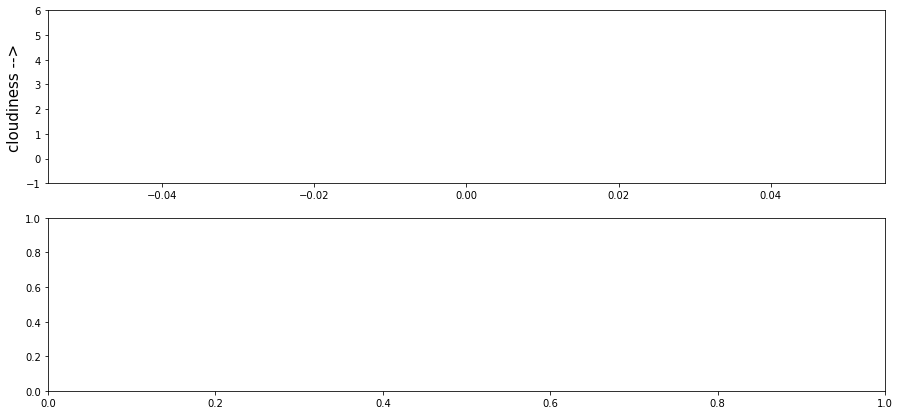

In [27]:
fig,ax=plt.subplots(2,1,figsize=(15,7))
ax[0].scatter(df07_cut.lats,df07_cut.cloud, s=5, c='b')
ax[0].set_ylabel('cloudiness -->',fontsize=15)
ax[0].set_ylim(-1,6)
ax[0].set_xlim(min(df07_cut.lats),max(df07_cut.lats))
ax[1].scatter(df07_cut.lats,df07_cut.photon_rate, s=5, c='k')
ax[1].set_ylim(0,20)
ax[1].set_xlim(min(df07_cut.lats),max(df07_cut.lats))
ax[1].set_ylabel('photon rate',fontsize=15)
ax[1].set_xlabel('latitude',fontsize=15)

You can see as the cloudiness increases from low/med confidence clear to high confidence cloudy, the photon rate drops

In [ ]:
#Romina - can we make a task out of this?